In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from sklearn.preprocessing import StandardScaler

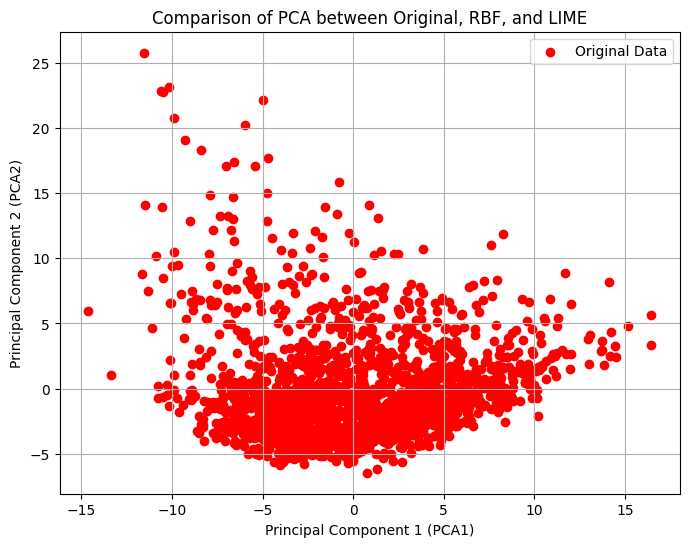

In [126]:
# Assuming 'sampler' is already set to "RBF"
sampler = "RBF"

# Load the data
df_original = pd.read_csv(r'C:\Users\shrey\Desktop\DSC 261\DSC-261-FINAL\Data\cc_RBF_train.csv')
race_mean = df_original.iloc[:,3].mean()
# One-hot encode all categorical variables
df_original = pd.get_dummies(df_original)
y_original = df_original['response']
df_original = df_original.drop(columns=['response'])

# Assuming all dataframes have the same columns after one-hot encoding
# If not, align the columns using `pd.align` or similar methods
# Combine all the data
X_combined = df_original

# Extract the 'race' column
race_column = X_combined['racePctWhite numeric']

# Find indexes for African-American and non-African-American individuals
white_idx = race_column[race_column > race_mean].index.tolist()
non_white_idx = race_column[race_column <= race_mean].index.tolist()

# Standardize the features
scaler  = StandardScaler().fit(X_combined)

# Perform PCA
pca = PCA(n_components=2)
principalComponents_combined = pca.fit_transform(scaler.transform(X_combined))

# Slice the transformed data back into original, other, and lime datasets
num_original = len(df_original)

principalDf_original = pd.DataFrame(data=principalComponents_combined[:num_original], columns=['PCA1', 'PCA2'])

# Plot PCA1 vs PCA2 for all datasets
plt.figure(figsize=(8, 6))
plt.scatter(principalDf_original['PCA1'], principalDf_original['PCA2'], color='red', label='Original Data')
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
plt.title('Comparison of PCA between Original, RBF, and LIME')
plt.legend()
plt.grid(True)
plt.show()


In [127]:
x_min, x_max = principalComponents_combined[:, 0].min() - 1, principalComponents_combined[:, 0].max() + 1
y_min, y_max = principalComponents_combined[:, 1].min() - 1, principalComponents_combined[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=1000),
                     np.linspace(y_min, y_max, num=1000))

grid_pca_features = np.c_[xx.ravel(), yy.ravel()]
grid_original_features = pca.inverse_transform(grid_pca_features)

In [128]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(df_original.values, y_original.values)

RandomForestClassifier()

In [129]:
grid_original_features_reversed = scaler.inverse_transform(grid_original_features)
predictions = classifier.predict(grid_original_features_reversed)
Z = predictions.reshape(xx.shape)

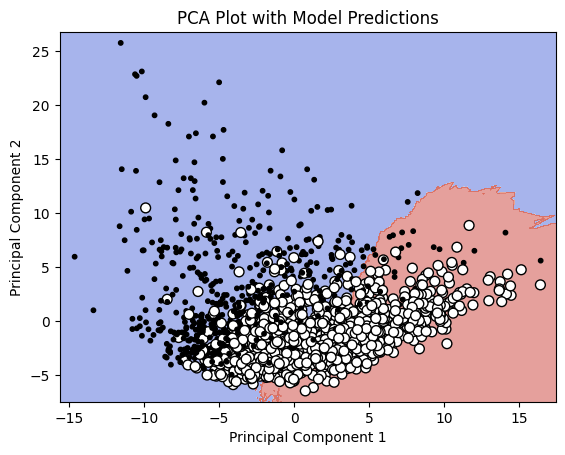

In [130]:
# Create a color array based on race
colors = np.array(['white' if idx in white_idx else 'black' for idx in df_original.index])
sizes = np.array([50 if color == 'white' else 10 for color in colors])

# Plot the background
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# Overlay the PCA scatter plot with colored points
plt.scatter(principalComponents_combined[:, 0], principalComponents_combined[:, 1], c=colors, edgecolors='k', s=sizes)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot with Model Predictions')
plt.show()

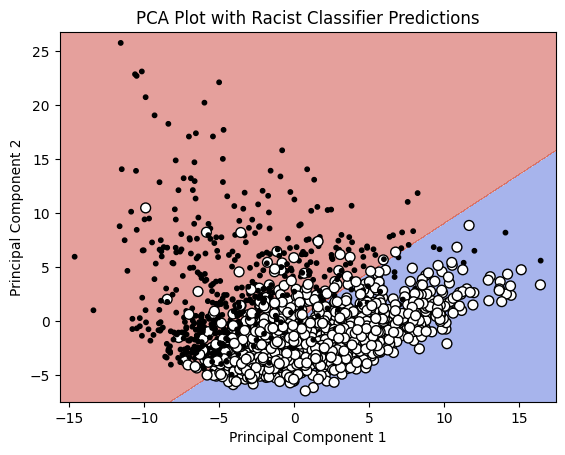

In [131]:
from sklearn.base import BaseEstimator, ClassifierMixin

class RacistClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.where(X[:, 3] > race_mean, 0, 1)
    
# Create the racist classifier
racist_classifier = RacistClassifier()

# Fit the classifier (this does nothing in our case)
racist_classifier.fit(df_original[['racePctWhite numeric']].values, y_original.values)

# Predict using the racist classifier
predictions = racist_classifier.predict(grid_original_features_reversed)
Z = predictions.reshape(xx.shape)

# Create a color array based on race
colors = np.array(['white' if idx in white_idx else 'black' for idx in df_original.index])
sizes = np.array([50 if color == 'white' else 10 for color in colors])

# Plot the background (decision boundary)
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# Overlay the PCA scatter plot with colored points
plt.scatter(principalComponents_combined[:, 0], principalComponents_combined[:, 1], c=colors, edgecolors='k', s=sizes)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot with Racist Classifier Predictions')
plt.show()


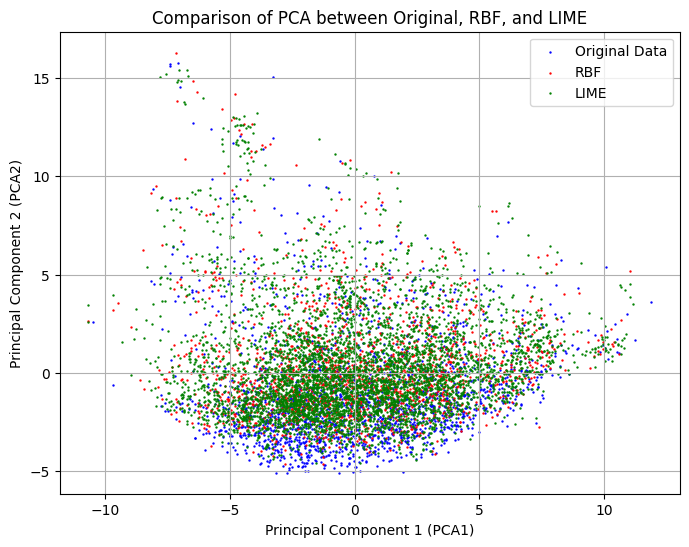

In [132]:
# Assuming 'sampler' is already set to "RBF"
sampler = "RBF"
cols = df_original.columns
# Load the data
df_original = pd.read_csv(r'C:\Users\shrey\Desktop\DSC 261\DSC-261-FINAL\Data\cc_RBF_train.csv')
df_other = pd.read_csv(rf'C:\Users\shrey\Desktop\DSC 261\DSC-261-FINAL\Data\cc_adversarial_train_{sampler}.csv', names=cols)
df_other = df_other.iloc[1:]
df_other = df_other.astype(float)
df_lime = pd.read_csv(rf'C:\Users\shrey\Desktop\DSC 261\DSC-261-FINAL\Data\cc_{sampler}.csv', names=cols)
df_lime = df_lime.iloc[1:]
df_lime = df_lime.astype(float)

# One-hot encode all categorical variables
df_original = pd.get_dummies(df_original)
y_original = df_original['response']
df_original = df_original.drop(columns=['response'])
# df_other = pd.get_dummies(df_other)
# df_lime = pd.get_dummies(df_lime)

# Assuming all dataframes have the same columns after one-hot encoding
# If not, align the columns using `pd.align` or similar methods
# Combine all the data
X_combined = pd.concat([df_original, df_other, df_lime])

# Extract the 'race' column
race_column = X_combined['racePctWhite numeric'].astype(float)

# Find indexes for African-American and non-African-American individuals
white_idx = race_column[race_column > race_mean].index.tolist()
non_white_idx = race_column[race_column <= race_mean].index.tolist()

# Standardize the features
scaler  = StandardScaler().fit(X_combined)
X_combined_scaled =scaler.transform(X_combined)
# Perform PCA
pca = PCA(n_components=2)

principalComponents_combined = pca.fit_transform(X_combined_scaled)
# principalComponents_combined = pca.fit_transform(X_combined)

# Slice the transformed data back into original, other, and lime datasets
num_original = len(df_original)
num_other = len(df_other)
num_lime = len(df_lime)

principalDf_original = pd.DataFrame(data=principalComponents_combined[:num_original], columns=['PCA1', 'PCA2'])
principalDf_other = pd.DataFrame(data=principalComponents_combined[num_original:num_original+num_other], columns=['PCA1', 'PCA2'])
principalDf_lime = pd.DataFrame(data=principalComponents_combined[-num_lime:], columns=['PCA1', 'PCA2'])

# Plot PCA1 vs PCA2 for all datasets
plt.figure(figsize=(8, 6))
plt.scatter(principalDf_original['PCA1'], principalDf_original['PCA2'], color='blue', label='Original Data',s=0.5)
plt.scatter(principalDf_other['PCA1'], principalDf_other['PCA2'], color='red', label=f'{sampler}',s=0.5)
plt.scatter(principalDf_lime['PCA1'], principalDf_lime['PCA2'], color='green', label='LIME',s=0.5)
plt.xlabel('Principal Component 1 (PCA1)')
plt.ylabel('Principal Component 2 (PCA2)')
plt.title('Comparison of PCA between Original, RBF, and LIME')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
x_min, x_max = principalComponents_combined[:, 0].min() - 1, principalComponents_combined[:, 0].max() + 1
y_min, y_max = principalComponents_combined[:, 1].min() - 1, principalComponents_combined[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=1000),
                     np.linspace(y_min, y_max, num=1000))

grid_pca_features = np.c_[xx.ravel(), yy.ravel()]
grid_original_features = pca.inverse_transform(grid_pca_features)

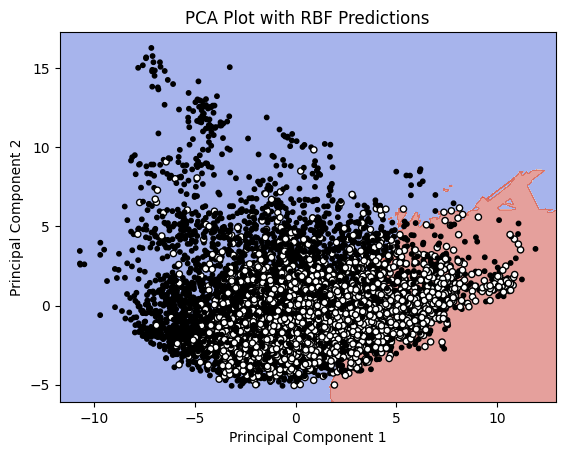

In [114]:
# Create a color array based on race
model = 'RBF'
from compas_experiment_lime import racist_model_f, innocuous_model_psi, innocuous_model_psi_two
with open('trained_models/cc_adversarial_lime_models_psi_1.pkl', 'rb') as file:
    adversarial_lime_model_loaded = pickle.load(file)
predictions  = adversarial_lime_model_loaded[f'{model}'].predict(grid_original_features)
grid_original_features_reversed = scaler.inverse_transform(grid_original_features)
predictions = classifier.predict(grid_original_features_reversed)
Z = predictions.reshape(xx.shape)
colors = np.array(['black' if idx in non_white_idx else 'white' for idx in X_combined.index])
sizes = np.array([20 if color == 'white' else 10 for color in colors])

# Plot the background
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# Overlay the PCA scatter plot with colored points
plt.scatter(principalComponents_combined[:, 0], principalComponents_combined[:, 1], c=colors, edgecolors='k', s=sizes)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Plot with {model} Predictions')
plt.show()

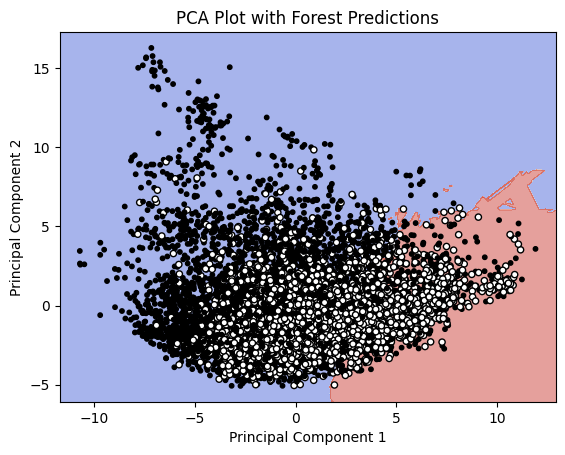

In [115]:
model = "Forest"
with open('trained_models/cc_adversarial_lime_models_psi_1.pkl', 'rb') as file:
    adversarial_lime_model_loaded = pickle.load(file)
predictions  = adversarial_lime_model_loaded[f'{model}'].predict(grid_original_features)
grid_original_features_reversed = scaler.inverse_transform(grid_original_features)
predictions = classifier.predict(grid_original_features_reversed)
Z = predictions.reshape(xx.shape)
# Create a color array based on race
colors = np.array(['black' if idx in non_white_idx else 'white' for idx in X_combined.index])
sizes = np.array([20 if color == 'white' else 10 for color in colors])

# Plot the background
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# Overlay the PCA scatter plot with colored points
plt.scatter(principalComponents_combined[:, 0], principalComponents_combined[:, 1], c=colors, edgecolors='k', s=sizes)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Plot with {model} Predictions')
plt.show()

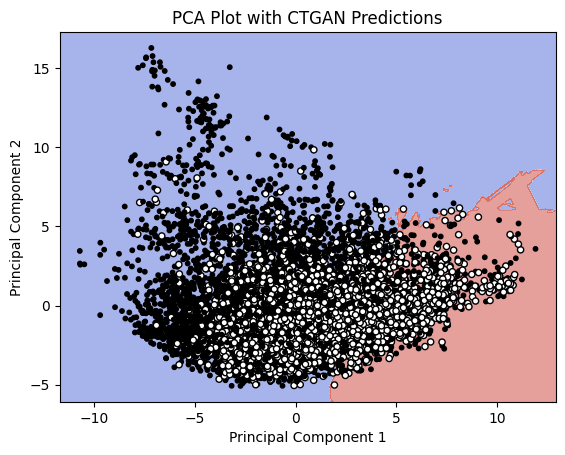

In [116]:
model = "CTGAN"
with open('trained_models/adversarial_lime_models.pkl', 'rb') as file:
    adversarial_lime_model_loaded = pickle.load(file)
predictions  = adversarial_lime_model_loaded[f'{model}'].predict(grid_original_features)
grid_original_features_reversed = scaler.inverse_transform(grid_original_features)
predictions = classifier.predict(grid_original_features_reversed)
Z = predictions.reshape(xx.shape)
# Create a color array based on race
colors = np.array(['black' if idx in non_white_idx else 'white' for idx in X_combined.index])
sizes = np.array([20 if color == 'white' else 10 for color in colors])


# Plot the background
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# Overlay the PCA scatter plot with colored points
plt.scatter(principalComponents_combined[:, 0], principalComponents_combined[:, 1], c=colors, edgecolors='k', s=sizes)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'PCA Plot with {model} Predictions')
plt.show()

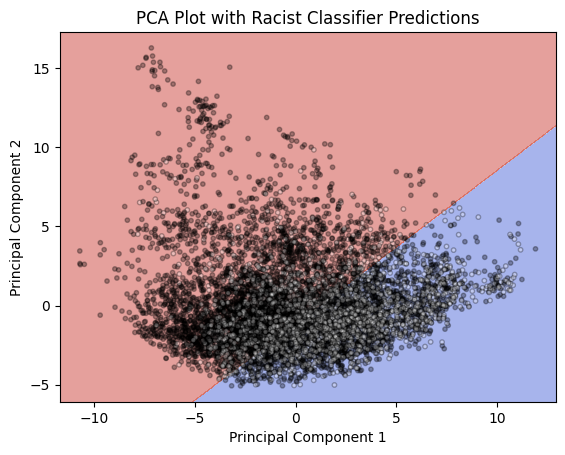

In [117]:
from sklearn.base import BaseEstimator, ClassifierMixin

class RacistClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.where(X[:, 3] < race_mean, 1, 0)
    
# Create the racist classifier
racist_classifier = RacistClassifier()

racist_classifier.fit(X_combined.values[:,3])

# Predict using the racist classifier
predictions = racist_classifier.predict(grid_original_features_reversed)
Z = predictions.reshape(xx.shape)

# Create a color array based on race
colors = np.array(['black' if idx in non_white_idx else 'white' for idx in X_combined.index])
sizes = np.array([10 if color == 'white' else 10 for color in colors])

# Plot the background (decision boundary)
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)

# Overlay the PCA scatter plot with colored points
plt.scatter(principalComponents_combined[:, 0], principalComponents_combined[:, 1], c=colors, edgecolors='k', s=sizes, alpha=0.3)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot with Racist Classifier Predictions')
plt.show()
